This notebook firstly evaluates if users and sites with different preferences can reach win-win outcomes and if these are better than contracts without the protocol. Next, it investigates if dishonest behavior can lead to better individual scores, making undesired behavior more attractive than the desired honest FOTE.

Chapter 1 (Qualitative Outcomes Analysis) comprises the first evaluation, chapter 2 (Manipulation) the second one. Chapter 3 should be a subchapter of Chapter 1, but relies on the data preparation of Chapter 2. 

# 1 Qualitative Outcomes Analysis
## Data Import, Overview and Preparation
In this section dependencies are imported and the csv files generated by the JS scripts are loaded into pandas dataframes. Each row is summarizes the contracts of an encounter between a user and a site persona. Each encounter has multiple contracts, as they were calculated for each variation in consent and content resolutions. Again, preferences on resolutions remain constant across personas. 

**Overview of variables**

| Variable            | Description                                                              | Example    |
|---------------------|------------------------------------------------------------|------------|
| `user`        | The relevancies of a user persona (Cost, Consent, Content)                                                           | LLH        |
| `site`     | The relevancies of a site persona (Cost, Consent, Content)                                                        | LLH        |
| `u_persona` | The user persona               | Balanced Brian |
| `s_persona` | The site persona               | Balanced Brief |
| `persona_fit` | Do the personas logicall fit (Zielgruppe/Target Group)              | Balanced Brief & Balanced Brian => TRUE|
| `default_old`     | Score of the conflict deal with fully accepted consent (reality)                                                        | 4000        |
| `default_new`     | Score of the conflict deal with fully rejected consent (agent default)                                                         | 4000        |
| `reality_assumption`     | in 3C contracts no conflict deal, but a deal observed/estimated in/from visual analysis.              | 4000        |
| `score_CCC`      | The score of the optimal contract. CCC (Cost, Consent, Content) in numbers from 2 to 5 express the number of resolutions. E.g. a 5 Cost options, 3 Consent options and 2 Content options result in a CCC of 532 | 6000       |
| `imbalance`   | calculation: score of user - score of site. Contract favors user if > 0 and vice versa. Balanced if 0.  | 0 balanced, > 0 favors user, < 0 favors site| 
| `consent_CCC`    | The consent granted for the contract of CCC                                                            | % |
| `content_CCC`          | The agreed content of contract CCC                                                                        | 80     |


In [270]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Palatino']
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'bold'

### Preparation of 2C Dataframe
Imported of csv data is mapped to the a pandas dataframe with the columns explained above. 

In [271]:

# load and present dataset 
two_c_df = pd.read_csv('./qualitative_2c.csv')

# csv creating script always puts one unnamed last column. removed here
two_c_df.drop(two_c_df.columns[-1], axis=1, inplace=True)
    
# from decimal relevancies to categorical relevancies
def toCategoricalRelevancies(text):
    text = text.replace("0.2", "L") # Issue is underweighted
    text = text.replace("0.5", "M") # Issues have same relevance
    text = text.replace("0.8", "H") # Issue is overweighted
    text = text.replace(" ", "")
    text = text.replace("MM", "M")
    return text

two_c_df['user'] = two_c_df['user'].apply(toCategoricalRelevancies)
two_c_df['site'] = two_c_df['site'].apply(toCategoricalRelevancies) 

# from categorical relevancies to personas
def toUserPersona(value):
     if value == 'M':
        return 'Balanced Brian'
     elif value == 'HL':
         return 'Privacy Priscilla'
     elif value == 'LH':
         return 'Content Connie & Tabloid Terry'
     
def toSitePersona(value):
     if value == 'M':
        return 'Balanced Brief'
     elif value == 'HL':
         return 'Tabloid Talker & Premium Press'
     elif value == 'LH':
         return 'Affordable News Network'
    
two_c_df['u_persona'] = two_c_df["user"].apply(toUserPersona)
two_c_df['s_persona'] = two_c_df["site"].apply(toSitePersona)

# Personas fit logically, e.g. Balanced Brian and Balanced Brief or Tabloid Terry and Tabloid Talker
two_c_df['persona_fit'] = ((two_c_df['u_persona'] == 'Balanced Brian') & (two_c_df['s_persona'] == 'Balanced Brief')) | \
                    ((two_c_df['u_persona'].isin(['Content Connie & Tabloid Terry', 'Tabloid Talker & Premium Press'])) & \
                     (two_c_df['s_persona'].isin(['Content Connie & Tabloid Terry', 'Tabloid Talker & Premium Press']))) | \
                    ((two_c_df['u_persona'] == 'Privacy Priscilla') & (two_c_df['s_persona'] == 'Affordable News Network'))


# from consent string to percentage
for name in ['consent_34', 'consent_64', 'consent_67']:
    two_c_df[name].fillna('0', inplace=True)


consent_options = 6

for name in ['consent_64', 'consent_67']:
    two_c_df[name] = two_c_df[name].apply(lambda value: 0 if value == '0' else(round(len(value.split())/consent_options*100,2)))
    two_c_df[name] = two_c_df[name].apply(lambda value: 'ALL' if value == 100.0 else ('REJECTED' if value == 0.0 else value))

consent_options = 3

for name in ['consent_34']:
    two_c_df[name] = two_c_df[name].apply(lambda value: 0 if value == '0' else(round(len(value.split())/consent_options*100,2)))
    two_c_df[name] = two_c_df[name].apply(lambda value: 'ALL' if value == 100.0 else ('REJECTED' if value == 0.0 else value))

# arrange order of columns
two_c_df = two_c_df[['user', 'site','u_persona', 's_persona', 'persona_fit', 'default_old', 'default_new', 'score_34', 'score_64', 'score_67', 'imbalance',
                   'consent_34', 'consent_64', 'consent_67', 'content_34', 'content_64', 'content_67']]

# show df
two_c_df

,user,site,u_persona,s_persona,persona_fit,default_old,default_new,score_34,score_64,score_67,imbalance,consent_34,consent_64,consent_67,content_34,content_64,content_67
0,HL,HL,Privacy Priscilla,Tabloid Talker & Premium Press,False,900,900,3480,3480,3480,-2,33.33,33.33,33.33,70,70,70
1,HL,LH,Privacy Priscilla,Affordable News Network,True,600,3600,7840,7840,7840,18,REJECTED,REJECTED,REJECTED,70,70,70
2,HL,M,Privacy Priscilla,Balanced Brief,False,750,2250,4950,4950,4950,35,33.33,16.67,16.67,70,70,70
3,LH,HL,Content Connie & Tabloid Terry,Tabloid Talker & Premium Press,True,3600,600,7520,7520,7520,-14,ALL,ALL,ALL,80,80,80
4,LH,LH,Content Connie & Tabloid Terry,Affordable News Network,False,2400,2400,7392,7396,7396,-4,33.33,50.0,50.0,70,70,70
5,LH,M,Content Connie & Tabloid Terry,Balanced Brief,False,3000,1500,7200,7200,7200,-28,ALL,ALL,ALL,70,70,70
6,M,HL,Balanced Brian,Tabloid Talker & Premium Press,False,2250,750,4730,4730,4730,-31,66.67,83.33,83.33,80,80,80
7,M,LH,Balanced Brian,Affordable News Network,False,1500,3000,7600,7600,7600,15,REJECTED,REJECTED,REJECTED,70,70,70
8,M,M,Balanced Brian,Balanced Brief,True,1875,1875,5250,5250,5250,-5,33.33,16.67,16.67,70,70,70


### Preparation of 3C Dataframe
Imported of csv data is mapped to the a pandas dataframe with the columns explained above. 

In [272]:
# load and present dataset 
three_c_df = pd.read_csv('./qualitative_3c.csv')

three_c_df

# csv creating script always puts one unnamed last column. removed here
three_c_df.drop(three_c_df.columns[-1], axis=1, inplace=True)

# from decimal relevancies to categorical relevancies
def toCategoricalRelevancies(text):
    text = text.replace("0.2", "L") # Issue is underweighted
    text = text.replace("0.33", "M") # Issues have same relevance
    text = text.replace("0.6", "H") # Issue is overweighted
    text = text.replace(" ", "")
    text = text.replace("MMM", "M")
    return text

three_c_df['user'] = three_c_df['user'].apply(toCategoricalRelevancies)
three_c_df['site'] = three_c_df['site'].apply(toCategoricalRelevancies) 

# from categorical relevancies to personas
def toUserPersona(value):
     if value == 'M':
        return 'Balanced Brian'
     elif value == 'HLL':
         return 'Tabloid Terry'
     elif value == 'LHL':
         return 'Privacy Priscilla'
     elif value == 'LLH':
         return 'Content Connie'
     
def toSitePersona(value):
     if value == 'M':
        return 'Balanced Brief'
     elif value == 'HLL':
         return 'Premium Press'
     elif value == 'LHL':
         return 'Tabloid Talker'
     elif value == 'LLH':
         return 'Affordable News Network'
    
three_c_df['u_persona'] = three_c_df["user"].apply(toUserPersona)
three_c_df['s_persona'] = three_c_df["site"].apply(toSitePersona)


# Personas fit logically, e.g. Balanced Brian and Balanced Brief or Tabloid Terry and Tabloid Talker
three_c_df['persona_fit'] = ((three_c_df['u_persona'] == 'Balanced Brian') & (three_c_df['s_persona'] == 'Balanced Brief')) | \
                            ((three_c_df['u_persona'] == 'Tabloid Terry') & (three_c_df['s_persona'] == 'Tabloid Talker')) | \
                            ((three_c_df['u_persona'] == 'Content Connie') & (three_c_df['s_persona'] == 'Premium Press')) | \
                            ((three_c_df['u_persona'] == 'Privacy Priscilla') & (three_c_df['s_persona'] == 'Affordable News Network'))

# from consent string to percentage
for name in ['consent_535', 'consent_565']:
    three_c_df[name].fillna('0', inplace=True)

consent_options = 6

for name in ['consent_565']:
    three_c_df[name] = three_c_df[name].apply(lambda value: 0 if value == '0' else(round(len(value.split())/consent_options*100,2)))
    three_c_df[name] = three_c_df[name].apply(lambda value: 'ALL' if value == 100.0 else ('REJECTED' if value == 0.0 else value))

consent_options = 3

for name in ['consent_535']:
    three_c_df[name] = three_c_df[name].apply(lambda value: 0 if value == '0' else(round(len(value.split())/consent_options*100,2)))
    three_c_df[name] = three_c_df[name].apply(lambda value: 'ALL' if value == 100.0 else ('REJECTED' if value == 0.0 else value))

# arrange order of columns
three_c_df = three_c_df[['user', 'site','u_persona', 's_persona', 'persona_fit', 'default_new', 'reality_assumption',  'score_535', 'score_565', 'imbalance',
                   'consent_535', 'consent_565', 'content_535', 'content_565','cost_535','cost_565']]

three_c_df

,user,site,u_persona,s_persona,persona_fit,default_new,reality_assumption,score_535,score_565,imbalance,consent_535,consent_565,content_535,content_565,cost_535,cost_565
0,HLL,HLL,Tabloid Terry,Premium Press,False,780,5084,5600,5600,10,ALL,ALL,80,80,1,1
1,HLL,LHL,Tabloid Terry,Tabloid Talker,True,780,5828,7200,7200,-10,ALL,ALL,80,80,1,1
2,HLL,LLH,Tabloid Terry,Affordable News Network,False,2340,5828,7216,7224,6,66.67,66.67,80,80,1,1
3,HLL,M,Tabloid Terry,Balanced Brief,False,1287,5524,6640,6640,-3,ALL,ALL,80,80,1,1
4,LHL,HLL,Privacy Priscilla,Premium Press,False,860,2788,6400,6400,0,REJECTED,REJECTED,80,80,20,20
5,LHL,LHL,Privacy Priscilla,Tabloid Talker,False,860,3196,4224,4224,-2,66.67,50.0,80,80,1,1
6,LHL,LLH,Privacy Priscilla,Affordable News Network,True,2580,3196,7000,7000,30,REJECTED,REJECTED,80,80,1,1
7,LHL,M,Privacy Priscilla,Balanced Brief,False,1419,3029,5418,5418,23,REJECTED,REJECTED,80,80,12,12
8,LLH,HLL,Content Connie,Premium Press,True,660,6068,6400,6400,0,REJECTED,50.0,80,80,12,12
9,LLH,LHL,Content Connie,Tabloid Talker,False,660,6956,7200,7200,-10,ALL,ALL,80,80,1,1


## Conflict Deal

### Old vs. New Conflict Deal

Answered Question: Is the conflict deal (“reject all” contract) better than the currently typical accept all” contract?

Input Parameters:

- `default_old`: accept all & 50% access
- `default_new`: reject all & 50% access

Metrics:

- gain = score(new conflict deal) − score(old conflict deal)

In [273]:
default_contracts_df = two_c_df[['u_persona','s_persona','persona_fit', 'default_old', 'default_new']]
default_contracts_df['gain'] = default_contracts_df['default_new'] - default_contracts_df['default_old']

default_contracts_df

/var/folders/p6/9ycc86_x3dx63xpjwy6z57n40000gn/T/ipykernel_57367/988536082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  default_contracts_df['gain'] = default_contracts_df['default_new'] - default_contracts_df['default_old']


,u_persona,s_persona,persona_fit,default_old,default_new,gain
0,Privacy Priscilla,Tabloid Talker & Premium Press,False,900,900,0
1,Privacy Priscilla,Affordable News Network,True,600,3600,3000
2,Privacy Priscilla,Balanced Brief,False,750,2250,1500
3,Content Connie & Tabloid Terry,Tabloid Talker & Premium Press,True,3600,600,-3000
4,Content Connie & Tabloid Terry,Affordable News Network,False,2400,2400,0
5,Content Connie & Tabloid Terry,Balanced Brief,False,3000,1500,-1500
6,Balanced Brian,Tabloid Talker & Premium Press,False,2250,750,-1500
7,Balanced Brian,Affordable News Network,False,1500,3000,1500
8,Balanced Brian,Balanced Brief,True,1875,1875,0


Observations:

- sum of gains is 0
- Privacy Priscilla & counterpart gained 4500 points
- Contetn Connie and Tabloid Terry  & counterpart los 4500 points

### Improvements in 2C Contracts

Answered question: Are optimal 2C contracts better than the conflict deal?

Input Parameters:

- `score_CC`: scores of optimal 2C contracts for different numbers of consent/content resolutions
- `default_new`: reject all & 50% access

Metrics:


- `gain` = ($\frac{\text{score\_CC}}{\text{default\_new}} - 1 ) * 100$

In [274]:
# --- 2C ---

# Any contract should be better than the default/conflict deal
score_columns = ['score_34','score_64','score_67']

# Find the minimum value in each row for the selected columns
min_score = two_c_df[score_columns].min(axis=1)

# Minimum Gain Ratio
gain_ratios = (min_score / two_c_df['default_new'] - 1) * 100

gain_ratios.name = '2C gains in %'

gain_ratios.describe().astype(int).to_frame()


,2C gains in %
count,9
mean,347
std,331
min,117
25%,153
50%,208
75%,380
max,1153


Observations

- Any optimal contract is better than the conflict deal (0 EUR, Rejected All, 50% Content)
- 2C
  - Median gain is 208%
  - Minimal gain is 117%

## Actual Deal vs. Optimal Contract

Answered question: Are optimal 3C contracts better than the average 3C contract without the protocol?

Assumption:

- cost = 6
- consent = all
- content = 80

Input Parameters:

- `score_CCC`: scores of optimal 3C contracts for different numbers of consent/content resolutions
- `reality_assumption`: {6 euro, full consent, 80% content}

Metrics:

- `diff_rel` = ($\frac{\text{score\_CCC}}{\text{reality\_assumption}} - 1 ) * 100$

In [275]:
actual_contracts_df = three_c_df[['u_persona','s_persona','persona_fit', 'reality_assumption', 'score_535']]
actual_contracts_df['diff'] = actual_contracts_df['score_535'] - actual_contracts_df['reality_assumption']
actual_contracts_df['diff_rel'] = round(100 * (actual_contracts_df['score_535'] / actual_contracts_df['reality_assumption']-1),2)
actual_contracts_df

/var/folders/p6/9ycc86_x3dx63xpjwy6z57n40000gn/T/ipykernel_57367/3779266324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_contracts_df['diff'] = actual_contracts_df['score_535'] - actual_contracts_df['reality_assumption']
/var/folders/p6/9ycc86_x3dx63xpjwy6z57n40000gn/T/ipykernel_57367/3779266324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_contracts_df['diff_rel'] = round(100 * (actual_contracts_df['score_535'] / actual_contracts_df['reality_assumption']-1),2)


,u_persona,s_persona,persona_fit,reality_assumption,score_535,diff,diff_rel
0,Tabloid Terry,Premium Press,False,5084,5600,516,10.15
1,Tabloid Terry,Tabloid Talker,True,5828,7200,1372,23.54
2,Tabloid Terry,Affordable News Network,False,5828,7216,1388,23.82
3,Tabloid Terry,Balanced Brief,False,5524,6640,1116,20.20
4,Privacy Priscilla,Premium Press,False,2788,6400,3612,129.56
5,Privacy Priscilla,Tabloid Talker,False,3196,4224,1028,32.17
6,Privacy Priscilla,Affordable News Network,True,3196,7000,3804,119.02
7,Privacy Priscilla,Balanced Brief,False,3029,5418,2389,78.87
8,Content Connie,Premium Press,True,6068,6400,332,5.47
9,Content Connie,Tabloid Talker,False,6956,7200,244,3.51


Observation:

Under the assumptions of mentioned above and the static preferences any optimal contract has a higher score than the assumed one in eality

Or in a pivot to plot gains within and across encounters: 

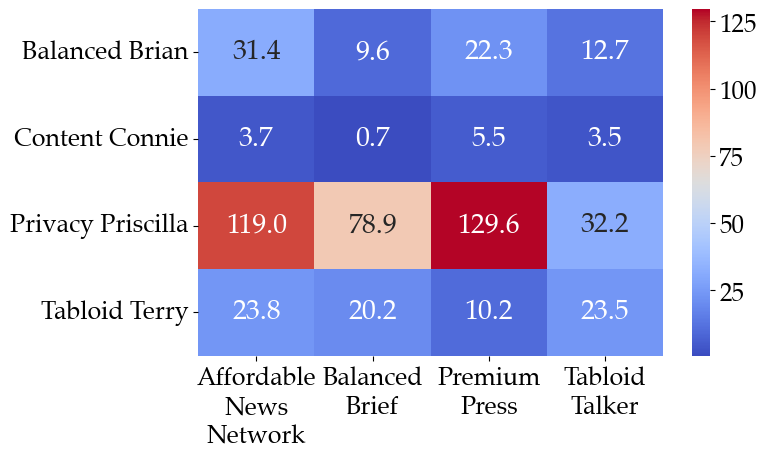

In [276]:
pivot_mean_diff = actual_contracts_df.pivot_table(index='u_persona', columns='s_persona', values='diff_rel',aggfunc='mean')

pivot_mean_diff.reset_index(inplace=True)

# Set the size of the plot
plt.figure(figsize=(7.5, 4.5))

# Create the heatmap plot
heatmap = sns.heatmap(pivot_mean_diff.set_index('u_persona'), cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 20})
heatmap.set_xticklabels(['Affordable\nNews\nNetwork','Balanced\nBrief', 'Premium\nPress', 'Tabloid\nTalker'], rotation=0)

# Set the title and labels
#plt.title('2C Scores by User and Site Persona')
plt.xlabel('')
plt.ylabel('')

# Show the plot
plt.show()

Analysis between Counterparts: 

In [244]:
# Improvements for persona_fit TRUE FALSE
diffs_3c_persona_fit = actual_contracts_df[['persona_fit','diff_rel']].groupby(['persona_fit']).describe().reset_index()
diffs_3c_persona_fit

persona_fit diff_rel                                                    \
                 count     mean        std   min     25%    50%      75%   
0       False     12.0  30.7550  37.463622  0.71  8.5475  21.23  31.6075   
1        True      4.0  39.4025  53.638796  5.47  8.5525  16.56  47.4100   

           
      max  
0  129.56  
1  119.02

Observation
- btw. counterparts: higher 75%
- non-counterparts: other stats are higher

Median Gain per Persona: 

In [245]:
# Improvements for personas
diffs_by_s_persona = actual_contracts_df[['s_persona', 'diff_rel']].groupby('s_persona').median().reset_index()
diffs_by_s_persona['persona_type'] = 'site'

# Calculate median of 'diff' grouped by 'u_persona'
diffs_by_u_persona = actual_contracts_df[['u_persona', 'diff_rel']].groupby('u_persona').median().reset_index()
diffs_by_u_persona['persona_type'] = 'user'

# Rename columns for concat
diffs_by_s_persona.rename(columns={'s_persona': 'persona'}, inplace=True)
diffs_by_u_persona.rename(columns={'u_persona': 'persona'}, inplace=True)

# Concat
diffs_3c_persona_fit = pd.concat([diffs_by_s_persona, diffs_by_u_persona], axis=0).reset_index(drop=True)

diffs_3c_persona_fit.sort_values(by='diff_rel')


,persona,diff_rel,persona_type
5,Content Connie,3.625,user
1,Balanced Brief,14.890,site
2,Premium Press,16.205,site
4,Balanced Brian,17.455,user
3,Tabloid Talker,18.095,site
7,Tabloid Terry,21.870,user
0,Affordable News Network,27.620,site
6,Privacy Priscilla,98.945,user


Observations: 
- COntent Connie gains little
- Privacy Priscilla has highest gains

## Granularization of Consent and Content Resolutions
Answered question: Does granularization of consent or content resolutions improve contracts?

### Granularization (2C)

Input Parameters

- `Score_CC`

- `Consent_CC`

- `Content_CC`

In [246]:
two_c_df[['score_34', 'score_64', 'score_67', 'consent_34','consent_64','consent_67','content_34','content_64','content_67',]]

,score_34,score_64,score_67,consent_34,consent_64,consent_67,content_34,content_64,content_67
0,3480,3480,3480,33.33,33.33,33.33,70,70,70
1,7840,7840,7840,REJECTED,REJECTED,REJECTED,70,70,70
2,4950,4950,4950,33.33,16.67,16.67,70,70,70
3,7520,7520,7520,ALL,ALL,ALL,80,80,80
4,7392,7396,7396,33.33,50.0,50.0,70,70,70
5,7200,7200,7200,ALL,ALL,ALL,70,70,70
6,4730,4730,4730,66.67,83.33,83.33,80,80,80
7,7600,7600,7600,REJECTED,REJECTED,REJECTED,70,70,70
8,5250,5250,5250,33.33,16.67,16.67,70,70,70


Observations

- Score is same in one row (Exception: row 4)
- Content is same in one row
- Consent Rejected/Accepted is same in one row
- Tradeoffs in consent can result in different tradeoffs for more consent options (e.g. row 4: 33.33 => 50.0 and row 0: 33.33 => 33.33)

Interpretation

- Granularization (more resolutions) does not lead to better contract scores
- The number of consent resolutions can change the consent tradeoff

In [247]:
consent_diffs_df = two_c_df[~two_c_df['consent_34'].isin(['ALL', 'REJECTED'])][['user', 'site', 'consent_34', 'consent_64']]
consent_diffs_df['diff']= consent_diffs_df['consent_34'] - consent_diffs_df['consent_64']

consent_34_stats = consent_diffs_df['consent_34'].astype(int).describe()

# Calculate descriptive statistics for 'consent_64' column
consent_64_stats = consent_diffs_df['consent_64'].astype(int).describe()

# Concatenate the two Series into a DataFrame
combined_stats_df = pd.concat([consent_34_stats, consent_64_stats], axis=1).drop(['std','count'])

# Transpose the DataFrame
combined_stats_df = combined_stats_df.T

combined_stats_df

,mean,min,25%,50%,75%,max
consent_34,39.6,33.0,33.0,33.0,33.0,66.0
consent_64,39.6,16.0,16.0,33.0,50.0,83.0


Observations

- Median and Mean Consent remain same
- More consent options enable less and more consent 

### Granularization (3C)

Input Parameters

- `Score_CCC`

- `Consent_CCC`

- `Content_CCC`

In [248]:
reduced = three_c_df[['score_535', 'score_565', 'consent_565','consent_535','content_535','content_565','cost_535','cost_565']]
reduced

,score_535,score_565,consent_565,consent_535,content_535,content_565,cost_535,cost_565
0,5600,5600,ALL,ALL,80,80,1,1
1,7200,7200,ALL,ALL,80,80,1,1
2,7216,7224,66.67,66.67,80,80,1,1
3,6640,6640,ALL,ALL,80,80,1,1
4,6400,6400,REJECTED,REJECTED,80,80,20,20
5,4224,4224,50.0,66.67,80,80,1,1
6,7000,7000,REJECTED,REJECTED,80,80,1,1
7,5418,5418,REJECTED,REJECTED,80,80,12,12
8,6400,6400,50.0,REJECTED,80,80,12,12
9,7200,7200,ALL,ALL,80,80,1,1


Observations

- Scores: Mostly same, some exceptions in row 2 and 15
- Consent Mostly Same, some exceptions in row 5 and 8
- Content always same
- Cost always same

Interpretation

- Granularization (more resolutions) does not lead to better contract scores
- The number of consent resolutions can **slightly** change the consent tradeoff

## Characteristics of Contracts

Answered question: Which are the characteristics of contracts, underlying the respective contract scores?

Objective: 

- Overview on absolute scores
- Overview on agreed consent or **Privacy Friendliness**
- Overview on agreed content
- Overview on agreed cost
- Relation between issues (cost, consent, content)



### Absolute Scores
Answered Question: Which personas (already) achieve the best contracts?

Input:

- `score_CC` and `score_CCC`
- `u_persona` and `s_persona`
- `persona_fit`

In [249]:
score_34_stats = two_c_df['score_34'].describe().astype(int).to_frame().drop(['count', 'mean', 'std'])

# Calculate descriptive statistics for 'score_535' column
score_535_stats = three_c_df['score_535'].describe().astype(int).to_frame().drop(['count', 'mean', 'std'])

# Concatenate the two DataFrames horizontally
combined_stats_df = pd.concat([score_34_stats, score_535_stats], axis=1)

# Output the result
combined_stats_df

,score_34,score_535
min,3480,4224
25%,4950,5618
50%,7200,6520
75%,7520,7050
max,7840,7216


Observations:

- minimum lower in 3C
- median higher in 2C
- max higher in 2C

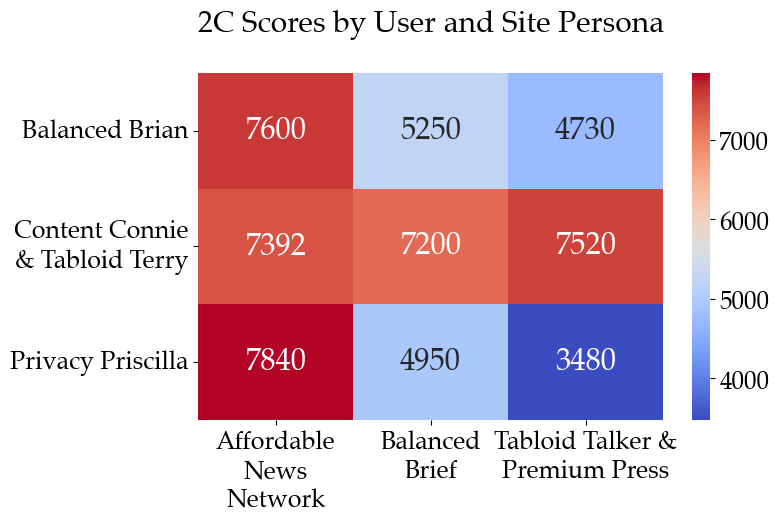

In [250]:
pivot_personas_scores = two_c_df.pivot_table(index='u_persona', columns='s_persona', values='score_34')

pivot_personas_scores.reset_index(inplace=True)

# Set the size of the plot
plt.figure(figsize=(7.5, 4.5))

# Create the heatmap plot
heatmap = sns.heatmap(pivot_personas_scores.set_index('u_persona'), cmap='coolwarm', annot=True, fmt="d", annot_kws={"size": 22})
heatmap.set_yticklabels(['Balanced Brian','Content Connie\n& Tabloid Terry','Privacy Priscilla'], rotation=0)
heatmap.set_xticklabels(['Affordable\nNews\nNetwork','Balanced\nBrief','Tabloid Talker &\nPremium Press'], rotation=0)

# Set the title and labels
plt.title('2C Scores by User and Site Persona\n')
plt.xlabel('')
plt.ylabel('')


# Show the plot
plt.show()

Observations
- Content Connie & Tabloid Terry have highest average score
- Privacy Priscilla has the lowest minimum scores
- Both Balanced Briand and Privacy Priscilla have higher maximum scores than Content Connie & Tabloid Terry

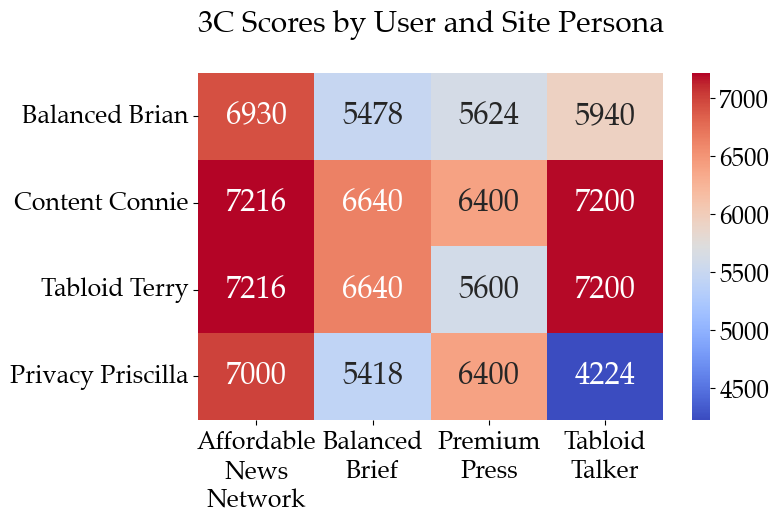

In [251]:
three_c_df['u_persona'] = pd.Categorical(three_c_df['u_persona'], categories=['Balanced Brian', 'Content Connie', 'Tabloid Terry', 'Privacy Priscilla'], ordered=True)

pivot_personas_scores_3c = three_c_df.pivot_table(index='u_persona', columns='s_persona', values='score_535')

pivot_personas_scores_3c.reset_index(inplace=True)
# Set the size of the plot
plt.figure(figsize=(7.5, 4.5))

# Create the heatmap plot
heatmap = sns.heatmap(pivot_personas_scores_3c.set_index('u_persona'), cmap='coolwarm', annot=True, fmt="d", annot_kws={"size": 22})
heatmap.set_xticklabels(['Affordable\nNews\nNetwork','Balanced\nBrief','Premium\nPress','Tabloid\nTalker'], rotation=0)

# Set the title and labels
plt.title('3C Scores by User and Site Persona\n')
plt.xlabel('')
plt.ylabel('')

# Show the plot
plt.show()

Observations

- Affordable News Network, Content Connie & Tabloid Terry reach the best contracts
- Balanced Brief and Tabloid Talker & Premium Press achieve the most satisfying results if their counterpart doesn't care about consent
- Privacy Priscilla can not achieve mutual gains with consent emphasizing sites

Can better contracts be achieve between counterparts?

In [252]:
# Descriptive stats for score_64 with persona_fit true and false
persona_fit_true_stats_64 = two_c_df[two_c_df['persona_fit'] == True]['score_64'].describe().drop(['count', 'mean', 'std'])
persona_fit_false_stats_64 = two_c_df[two_c_df['persona_fit'] == False]['score_64'].describe().drop(['count', 'mean', 'std'])

# Descriptive stats for score_565 with persona_fit true and false
persona_fit_true_stats_565 = three_c_df[three_c_df['persona_fit'] == True]['score_565'].describe().drop(['count', 'mean', 'std'])
persona_fit_false_stats_565 = three_c_df[three_c_df['persona_fit'] == False]['score_565'].describe().drop(['count', 'mean', 'std'])

# Merge horizontally
merged_persona_fit_scores = pd.concat([persona_fit_true_stats_64, persona_fit_false_stats_64, persona_fit_true_stats_565, persona_fit_false_stats_565], axis=1)
merged_persona_fit_scores.columns = ['persona_fit_True_64', 'persona_fit_False_64','persona_fit_True_565', 'persona_fit_False_565']

merged_persona_fit_scores

,persona_fit_True_64,persona_fit_False_64,persona_fit_True_565,persona_fit_False_565
min,5250.0,3480.0,5548.0,4224.0
25%,6385.0,4785.0,6187.0,5618.0
50%,7520.0,6075.0,6700.0,6520.0
75%,7680.0,7347.0,7050.0,6997.5
max,7840.0,7600.0,7200.0,7224.0


Observations

- 2C:
  - If personas fit, then min to max are higher
- 3C
  - If personas DONT fit, the top 50% of contracts are better
  - however, minimum and 25% quantile are worse
- 2C max scores are higher than 3C max scores

### Imbalance

Answered Question: Nash-optimal contracts are efficient, but are they fair?

**Metric**: 

- `imbalance` = score of user - score of site

Explanation: 
- If imbalance > 0: Favors the user
- Else If imabalance < 0: Favors the site
- Else: balanced
- **significance:** >10 or < -10
- **very imbalanced:** absolute value roughly > 30

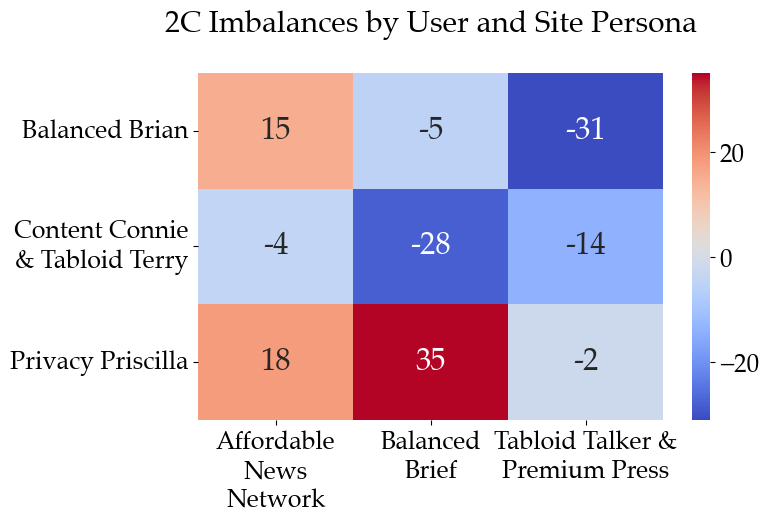

In [253]:
pivot_personas_imbalance = two_c_df.pivot_table(index='u_persona', columns='s_persona', values='imbalance',)

pivot_personas_imbalance.reset_index(inplace=True)

# Set the size of the plot
plt.figure(figsize=(7.5, 4.5))

# Create the heatmap plot
heatmap = sns.heatmap(pivot_personas_imbalance.set_index('u_persona'), cmap='coolwarm', annot=True, fmt="d", annot_kws={"size": 22})
heatmap.set_yticklabels(['Balanced Brian','Content Connie\n& Tabloid Terry','Privacy Priscilla'], rotation=0)
heatmap.set_xticklabels(['Affordable\nNews\nNetwork','Balanced\nBrief','Tabloid Talker &\nPremium Press'], rotation=0)

# Set the title and labels
plt.title('2C Imbalances by User and Site Persona\n')
plt.xlabel('')
plt.ylabel('')

# Show the plot
plt.show()

Observations

- 6 of 9 contracts are imbalanced (absolute value > 10)
  - 3 favor users
  - 3 favor sites
- 3 contracts are very imbalanced (absolute value roughly > 30)
  - 1 favors Balanced Brief
  - 1 favors TT & PP
  - 1 favors Privacy Priscilla
- between counterparts: 
  - Privacy Priscilla nd Affordable News Network favors user
  - TT && PP and CC & TT favors site

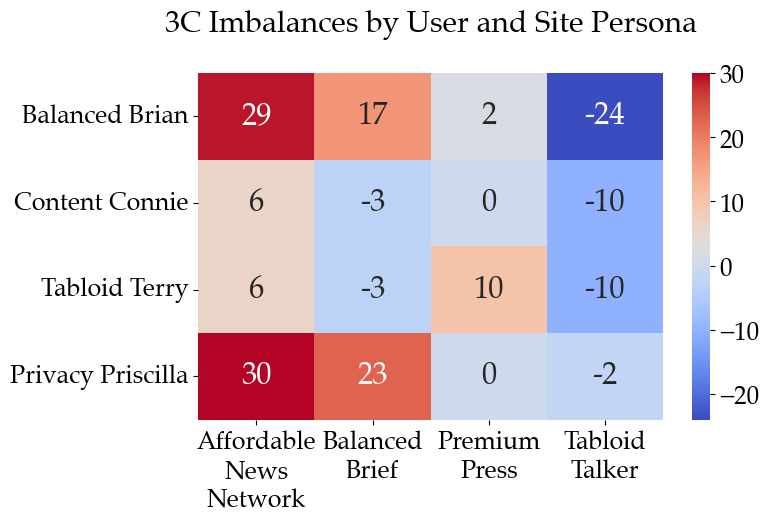

In [254]:
three_c_df['u_persona'] = pd.Categorical(three_c_df['u_persona'], categories=['Balanced Brian', 'Content Connie', 'Tabloid Terry', 'Privacy Priscilla'], ordered=True)

pivot_personas_imbalances_3c = three_c_df.pivot_table(index='u_persona', columns='s_persona', values='imbalance')

pivot_personas_imbalances_3c.reset_index(inplace=True)
# Set the size of the plot
plt.figure(figsize=(7.5, 4.5))

# Create the heatmap plot
heatmap = sns.heatmap(pivot_personas_imbalances_3c.set_index('u_persona'), cmap='coolwarm', annot=True, fmt="d", annot_kws={"size": 22})
heatmap.set_xticklabels(['Affordable\nNews\nNetwork','Balanced\nBrief','Premium\nPress','Tabloid\nTalker'], rotation=0)

# Set the title and labels
plt.title('3C Imbalances by User and Site Persona\n')
plt.xlabel('')
plt.ylabel('')

# Show the plot
plt.show()

Observations

- 5 of 16 contracts are imbalanced (absolute value > 10)
  - 4 favor users
  - 1 favors sites
- 2 contracts are very imbalanced (absolute value roughly > 30)
  - 1 favors Balanced Brian
  - 1 favors Privacy Priscilla
- between counterparts: 
  - Privacy Priscilla nd Affordable News Network favors user
  - Balanced...: favor user

### Consent
Answered Question: How privacy preserving are outcomes?

Input:

- 2C: `consent_34`, `consent_64`, `consent_67`
- 3C: `consent_535`, `consent_565`
- Personas: `u_persona` (user) and `s_persona` (site)
- Counterpart fit: `persona_fit`


In [255]:
# 3c DF
consent_counts_2c_df = pd.concat([two_c_df['consent_34'], two_c_df['consent_64'], two_c_df['consent_67']]).value_counts().to_frame()
consent_counts_2c_df = consent_counts_2c_df.reset_index()
consent_counts_2c_df.columns = ['Consent', 'Count']
consent_counts_2c_df['Consent'] = pd.Categorical(consent_counts_2c_df['Consent'], categories=['REJECTED', 16.67, 33.33, 50.0, 66.67, 83.33, 'ALL'], ordered=True)
consent_counts_2c_df = consent_counts_2c_df.sort_values(by='Consent')
consent_counts_2c_df

# 3c DF
consent_counts_df = pd.concat([three_c_df['consent_535'], three_c_df['consent_565']]).value_counts().to_frame()
consent_counts_df = consent_counts_df.reset_index()
consent_counts_df.columns = ['Consent', 'Count']
consent_counts_df['Consent'] = pd.Categorical(consent_counts_df['Consent'], categories=['REJECTED', 33.33, 50.0, 66.67, 'ALL'], ordered=True)
consent_counts_df = consent_counts_df.sort_values(by='Consent')
consent_counts_df
consent_counts_df

# Merge
merged_consent_counts_df = consent_counts_2c_df.merge(consent_counts_df, how='outer', on='Consent', suffixes=('_2c', '_3c'))

# Make comparable
#total = merged_consent_counts_df['Count_2c'].sum()
#merged_consent_counts_df['Count_2c'] = round((merged_consent_counts_df['Count_2c']/total)*100,2)

#total = merged_consent_counts_df['Count_3c'].sum()
#merged_consent_counts_df['Count_3c'] = round((merged_consent_counts_df['Count_3c']/total)*100,2)

# Output the result
merged_consent_counts_df



,Consent,Count_2c,Count_3c
0,REJECTED,6,11.0
1,16.67,4,NaN
2,33.33,6,1.0
3,50.0,2,2.0
4,66.67,1,6.0
5,83.33,2,NaN
6,ALL,6,12.0


Observations

- ACCEPTED and REJECTED are more common in 3C
- ACCEPTED and REJECTED are equally common in 2C
- 2C has a tendency towards lower quantiles
- 3C has a tendency towards higher quantiles

In [256]:
# Relate user personas to site personas
pivot_personas_consent = two_c_df.pivot(index='u_persona', columns='s_persona', values='consent_64')

pivot_personas_consent.reset_index(inplace=True)

#print(pivot_personas_consent.to_string(index=False))
# Function to apply style to specific cells
def highlight_cell(x):
    color = 'background-color: yellow'
    df_styler = pd.DataFrame('', index=x.index, columns=x.columns)
    cells = [(0,2), (1,3), (2,1)]
    for c in cells:
        df_styler.iloc[c] = color
    
    return df_styler

pivot_personas_consent = pivot_personas_consent.style.apply(highlight_cell, axis=None).format(lambda x: "{:.2f}".format(x) if not isinstance(x, str) else x)

pivot_personas_consent

s_persona,u_persona,Affordable News Network,Balanced Brief,Tabloid Talker & Premium Press
0,Balanced Brian,REJECTED,16.67,83.33
1,Content Connie & Tabloid Terry,50.00,ALL,ALL
2,Privacy Priscilla,REJECTED,16.67,33.33


Observations:

- the higher a user prioritizes consent, the less consent agreed on
- vice versa for site

In [257]:
# Relate user personas to site personas
pivot_personas_consent = three_c_df.pivot(index='u_persona', columns='s_persona', values='consent_565')

pivot_personas_consent.reset_index(inplace=True)

# Function to apply style to specific cells
def highlight_cell(x):
    color = 'background-color: yellow'
    df_styler = pd.DataFrame('', index=x.index, columns=x.columns)
    cells = [(0,2), (1,3), (2,4), (3,1)]
    for c in cells:
        df_styler.iloc[c] = color
    
    return df_styler


# Apply style to the pivot table DataFrame
pivot_personas_consent = pivot_personas_consent.style.apply(highlight_cell, axis=None).format(lambda x: "{:.2f}".format(x) if not isinstance(x, str) else x)
            
#print(pivot_personas_consent.to_string(index=False)
pivot_personas_consent

s_persona,u_persona,Affordable News Network,Balanced Brief,Premium Press,Tabloid Talker
0,Balanced Brian,REJECTED,66.67,REJECTED,ALL
1,Content Connie,66.67,ALL,50.00,ALL
2,Tabloid Terry,66.67,ALL,ALL,ALL
3,Privacy Priscilla,REJECTED,REJECTED,REJECTED,50.00


### Content
Answered Question: Which content resolutions are observed in which interactions?

Input:

- 2C: `content_34`, `content_64`, `content_67`
- 3C: `content_535`, `content_565`
- Personas: `u_persona` (user) and `s_persona` (site)
- Counterpart fit: `persona_fit`

In [258]:
content_counts_df = pd.concat([two_c_df['content_34'], two_c_df['content_64'], two_c_df['content_67']]).value_counts().to_frame()
content_counts_df = content_counts_df.reset_index()
content_counts_df.columns = ['Content', 'Count_2C']

content_counts_3c_df = pd.concat([three_c_df['content_535'], three_c_df['content_565']]).value_counts().to_frame()
content_counts_3c_df = content_counts_3c_df.reset_index()
content_counts_3c_df.columns = ['Content', 'Count_3C']

content_counts_df = pd.merge(content_counts_df, content_counts_3c_df, on='Content', how='outer')
content_counts_df

,Content,Count_2C,Count_3C
0,70,21,NaN
1,80,6,32.0


Observations:

- 2C: mostly 70%
- 3C: 
  - **even Content Connie gets 80% max.**
  - **even if 20 Eur were paid, maximum 80% of content would be granted**

In [259]:
pivot_personas_content = two_c_df.pivot(index='u_persona', columns='s_persona', values='content_64')

pivot_personas_content.reset_index(inplace=True)

#print(pivot_personas_consent.to_string(index=False))

pivot_personas_content

s_persona,u_persona,Affordable News Network,Balanced Brief,Tabloid Talker & Premium Press
0,Balanced Brian,70,70,80
1,Content Connie & Tabloid Terry,70,70,80
2,Privacy Priscilla,70,70,70


Observations

- minimum 70% of content
- 80% reached, if user value content more than their counterpart

### Cost in 3C
Answered Question: Which cost resolutions are observed in which interactions?

Input:

- 3C: `cost_535`, `cost_565`
- Personas: `u_persona` (user) and `s_persona` (site)
- Counterpart fit: `persona_fit`

In [260]:
cost_counts_df = pd.concat([three_c_df['cost_535'], three_c_df['cost_565']]).value_counts(normalize=True).to_frame()
cost_counts_df = cost_counts_df.reset_index()
cost_counts_df.columns = ['Cost', 'Count_%']

cost_counts_df['Count_%'] = (cost_counts_df['Count_%'] * 100).map("{:.2f}".format)

cost_counts_df

,Cost,Count_%
0,1,75.00
1,12,18.75
2,20,6.25


Observations:

- Cost of 1 in 75% of cases
- 12, 20 are rare
- MISSING: 0 and 6


In [261]:
pivot_personas_cost = three_c_df.pivot(index='u_persona', columns='s_persona', values='cost_565')

pivot_personas_cost.reset_index(inplace=True)

#print(pivot_personas_cost.to_string(index=False))

pivot_personas_cost

s_persona,u_persona,Affordable News Network,Balanced Brief,Premium Press,Tabloid Talker
0,Balanced Brian,1,1,12,1
1,Content Connie,1,1,12,1
2,Tabloid Terry,1,1,1,1
3,Privacy Priscilla,1,12,20,1


### Between Issues
Answered Question: Which is the relation between cost and consent?

In [262]:
three_c_df.groupby([ 'cost_565','consent_565',]).size().reset_index(name='count').sort_values(by='cost_565')

,cost_565,consent_565,count
0,1,50.0,1
1,1,66.67,3
2,1,ALL,6
3,1,REJECTED,2
4,12,50.0,1
5,12,REJECTED,2
6,20,REJECTED,1


Observations

- Same cost different consent
- 1 Eur: probably high consent (100% or 66%)
- REJECTED possible for 1 and 20 Eur

In [263]:
three_c_df.groupby([ 'cost_565','content_565',]).size().reset_index(name='count').sort_values(by='cost_565')

,cost_565,content_565,count
0,1,80,12
1,12,80,3
2,20,80,1


Observations

- Content always 80%
- Even for 20Eur only 80%

# 2 Manipulation

Objective: which persona can reach better individual scores by impersonating another persona?

Metric: individual score of a party for a contract

Approach:
1. for each contract calculate the score other parties would give it
2. if that score is higher, than the score a party can achieve when being honest, color its cell

Date Cleaning: 
1. take dataframes from first analysis
2. import preferences for personas
3. enrich dataframes (1.) with scores as defined in the approach

## 2C Negotiations
### Data Preparation

Load the data and calculalate as if scores:

users:
- PP: Prviacy Priscilla
- CC_TT: Content Connie & Tabloid Terry
- BB: Balanced Brian

sites: 
- PP_TT: Premium Press & Tabloid Talker
- AFN: Afforable News Network
- BBrief: Balanced Brief


In [264]:

# load and present dataset 
manip_2c_df = pd.read_csv('./qualitative_2c.csv')

# csv creating script always puts one unnamed last column. removed here
manip_2c_df.drop(manip_2c_df.columns[-1], axis=1, inplace=True)
    
# from decimal relevancies to categorical relevancies
def toCategoricalRelevancies(text):
    text = text.replace("0.2", "L") # Issue is underweighted
    text = text.replace("0.5", "M") # Issues have same relevance
    text = text.replace("0.8", "H") # Issue is overweighted
    text = text.replace(" ", "")
    text = text.replace("MM", "M")
    return text

manip_2c_df['user'] = manip_2c_df['user'].apply(toCategoricalRelevancies)
manip_2c_df['site'] = manip_2c_df['site'].apply(toCategoricalRelevancies) 

# from categorical relevancies to personas
def toUserPersona(value):
     if value == 'M':
        return 'Balanced Brian'
     elif value == 'HL':
         return 'Privacy Priscilla'
     elif value == 'LH':
         return 'Content Connie & Tabloid Terry'
     
def toSitePersona(value):
     if value == 'M':
        return 'Balanced Brief'
     elif value == 'HL':
         return 'Tabloid Talker & Premium Press'
     elif value == 'LH':
         return 'Affordable News Network'
    
manip_2c_df['u_persona'] = manip_2c_df["user"].apply(toUserPersona)
manip_2c_df['s_persona'] = manip_2c_df["site"].apply(toSitePersona)

# Personas fit logically, e.g. Balanced Brian and Balanced Brief or Tabloid Terry and Tabloid Talker
manip_2c_df['persona_fit'] = ((manip_2c_df['u_persona'] == 'Balanced Brian') & (manip_2c_df['s_persona'] == 'Balanced Brief')) | \
                    ((manip_2c_df['u_persona'].isin(['Content Connie & Tabloid Terry', 'Tabloid Talker & Premium Press'])) & \
                     (manip_2c_df['s_persona'].isin(['Content Connie & Tabloid Terry', 'Tabloid Talker & Premium Press']))) | \
                    ((manip_2c_df['u_persona'] == 'Privacy Priscilla') & (manip_2c_df['s_persona'] == 'Affordable News Network'))


# from consent string to percentage
for name in ['consent_34', 'consent_64', 'consent_67']:
    manip_2c_df[name].fillna('0', inplace=True)


#consent_options = 6

#for name in ['consent_64', 'consent_67']:
 #   manip_2c_df[name] = manip_2c_df[name].apply(lambda value: 0 if value == '0' else(round(len(value.split())/consent_options*100,2)))
 #   manip_2c_df[name] = manip_2c_df[name].apply(lambda value: 'ALL' if value == 100.0 else ('REJECTED' if value == 0.0 else value))
#
#consent_options = 3

# arrange order of columns
manip_2c_df = manip_2c_df[['u_persona', 's_persona', 'score_64', 'imbalance', 'consent_64', 'content_64']]

# show df
manip_2c_df

#+ u_score + s_score + as_PP + as_CC + as_BB + as_ANN + as_BB + as_TT

# manip_2c_df['u_score'] = (0.8 * (1 - 0.5) + 0.2 * 0.9 ) * 100

#u_const_pref * u_cons_score

# scores user and sites gave the consent and content resolutions
u_cons_scores = {
    "personalizedAds identification" : 0.5,
    "0" : 1,
    "identification" : 0.9,
    "analytics marketing personalizedContent personalizedAds externalContent identification" : 0,
    "personalizedContent externalContent identification" : 0.7,
    "personalizedAds":0.6,
    "personalizedContent personalizedAds externalContent": 0.4,
    "personalizedContent personalizedAds externalContent identification": 0.3,
    "personalizedAds externalContent identification": 0.4,
    "analytics personalizedContent personalizedAds externalContent identification":0.1
}
s_cons_scores = {
    "personalizedAds identification" : 0.5,
    "0" : 0,
    "identification" : 0.1,
    "analytics marketing personalizedContent personalizedAds externalContent identification" : 1,
    "personalizedContent externalContent identification" : 0.3,
    "personalizedAds":0.4,
    "personalizedContent personalizedAds externalContent": 0.6,
    "personalizedContent personalizedAds externalContent identification": 0.7,
    "personalizedAds externalContent identification": 0.6,
    "analytics personalizedContent personalizedAds externalContent identification":0.9
}
u_cont_scores = {
    70 : 1,
    80: 0.9
}

s_cont_scores = {
    70 : 1,
    80 : 0.7
}

# map the static scores to the columns containing the keys of the maps
manip_2c_df['u_cons_scores'] = manip_2c_df['consent_64'].map(u_cons_scores)
manip_2c_df['s_cons_scores'] = manip_2c_df['consent_64'].map(s_cons_scores)

manip_2c_df['u_cont_scores'] = manip_2c_df['content_64'].map(u_cont_scores)
manip_2c_df['s_cont_scores'] = manip_2c_df['content_64'].map(s_cont_scores)

# calculate 1 column with original scores of respective user
manip_2c_df.loc[manip_2c_df['u_persona'] == 'Privacy Priscilla', 'u_score'] = (
    100 * (0.8 * manip_2c_df['u_cons_scores'] + 0.2 * manip_2c_df['u_cont_scores'])
)

manip_2c_df.loc[manip_2c_df['u_persona'] == 'Balanced Brian', 'u_score'] = (
    100 * (0.5 * manip_2c_df['u_cons_scores'] + 0.5 * manip_2c_df['u_cont_scores'])
)

manip_2c_df.loc[manip_2c_df['u_persona'] == 'Content Connie & Tabloid Terry', 'u_score'] = (
    100 * (0.2 * manip_2c_df['u_cons_scores'] + 0.8 * manip_2c_df['u_cont_scores'])
)

# calculate 1 column with original scores of respective site
manip_2c_df.loc[manip_2c_df['s_persona'] == 'Affordable News Network', 's_score'] = (
    100 * (0.2 * manip_2c_df['s_cons_scores'] + 0.8 * manip_2c_df['s_cont_scores'])
)

manip_2c_df.loc[manip_2c_df['s_persona'] == 'Balanced Brief', 's_score'] = (
    100 * (0.5 * manip_2c_df['s_cons_scores'] + 0.5 * manip_2c_df['s_cont_scores'])
)

manip_2c_df.loc[manip_2c_df['s_persona'] == 'Tabloid Talker & Premium Press', 's_score'] = (
    100 * (0.8 * manip_2c_df['s_cons_scores'] + 0.2 * manip_2c_df['s_cont_scores'])
)

# scores : if user were other persona it would rate with this score
manip_2c_df['as_PP'] = 100 * (0.8 * manip_2c_df['u_cons_scores'] + 0.2 * manip_2c_df['u_cont_scores'])
manip_2c_df['as_CC_TT'] = 100 * (0.2 * manip_2c_df['u_cons_scores'] + 0.8 * manip_2c_df['u_cont_scores'])
manip_2c_df['as_BB'] = 100 * (0.5 * manip_2c_df['u_cons_scores'] + 0.5 * manip_2c_df['u_cont_scores'])

# scores : if site were other persona it would rate with this score
manip_2c_df['as_AFN'] = 100 * (0.2 * manip_2c_df['s_cons_scores'] + 0.8 * manip_2c_df['s_cont_scores'])
manip_2c_df['as_TT_PP'] = 100 * (0.8 * manip_2c_df['s_cons_scores'] + 0.2 * manip_2c_df['s_cont_scores'])
manip_2c_df['as_BBrief'] = 100 * (0.5 * manip_2c_df['s_cons_scores'] + 0.5 * manip_2c_df['s_cont_scores'])



manip_2c_df

,u_persona,s_persona,score_64,imbalance,consent_64,content_64,u_cons_scores,s_cons_scores,u_cont_scores,s_cont_scores,u_score,s_score,as_PP,as_CC_TT,as_BB,as_AFN,as_TT_PP,as_BBrief
0,Privacy Priscilla,Tabloid Talker & Premium Press,3480,-2,personalizedAds identification,70,0.5,0.5,1.0,1.0,60.0,60.0,60.0,90.0,75.0,90.0,60.0,75.0
1,Privacy Priscilla,Affordable News Network,7840,18,0,70,1.0,0.0,1.0,1.0,100.0,80.0,100.0,100.0,100.0,80.0,20.0,50.0
2,Privacy Priscilla,Balanced Brief,4950,35,identification,70,0.9,0.1,1.0,1.0,92.0,55.0,92.0,98.0,95.0,82.0,28.0,55.0
3,Content Connie & Tabloid Terry,Tabloid Talker & Premium Press,7520,-14,analytics marketing personalizedContent person...,80,0.0,1.0,0.9,0.7,72.0,94.0,18.0,72.0,45.0,76.0,94.0,85.0
4,Content Connie & Tabloid Terry,Affordable News Network,7396,-4,personalizedContent externalContent identifica...,70,0.7,0.3,1.0,1.0,94.0,86.0,76.0,94.0,85.0,86.0,44.0,65.0
5,Content Connie & Tabloid Terry,Balanced Brief,7200,-28,analytics marketing personalizedContent person...,70,0.0,1.0,1.0,1.0,80.0,100.0,20.0,80.0,50.0,100.0,100.0,100.0
6,Balanced Brian,Tabloid Talker & Premium Press,4730,-31,analytics personalizedContent personalizedAds ...,80,0.1,0.9,0.9,0.7,50.0,86.0,26.0,74.0,50.0,74.0,86.0,80.0
7,Balanced Brian,Affordable News Network,7600,15,0,70,1.0,0.0,1.0,1.0,100.0,80.0,100.0,100.0,100.0,80.0,20.0,50.0
8,Balanced Brian,Balanced Brief,5250,-5,personalizedAds,70,0.6,0.4,1.0,1.0,80.0,70.0,68.0,92.0,80.0,88.0,52.0,70.0


### Analysis

Formatting to visually understand who can obtain better contracts by manipulation. Cells are colored if a persona can achieve a better contract by impersonation. 

In [265]:
def highlight_greater_than_own_value(col):
    color = 'background-color: yellow'
    color_site = 'background-color: orange'
    color_actual = 'font-style: italic'
    
    style = ["" for val in col]
    if col.name == 'as_PP':
        #origninal scores
        style[0] = color_actual 
        style[1] = color_actual 
        style[2] = color_actual

        # with TT PP
        style[3] = color if col[3] > col[0] else ''
        style[6] = color if col[6] > col[0] else ''

        # with AFN
        style[4] = color if col[4] > col[1] else ''
        style[7] = color if col[7] > col[1] else ''

        # with BBrief
        style[5] = color if col[5] > col[2] else ''
        style[8] = color if col[8] > col[2] else ''
    
    if col.name == 'as_CC_TT':
        #origninal scores
        style[3] = color_actual 
        style[4] = color_actual 
        style[5] = color_actual

        # with TT PP
        style[0] = color if col[0] > col[3] else ''
        style[6] = color if col[6] > col[3] else ''

        # with AFN
        style[1] = color if col[1] > col[4] else ''
        style[7] = color if col[7] > col[4] else ''

        # with BBrief
        style[2] = color if col[2] > col[5] else ''
        style[8] = color if col[8] > col[5] else ''


    if col.name == 'as_BB':
        #origninal scores
        style[6] = color_actual 
        style[7] = color_actual 
        style[8] = color_actual

        # with TT PP
        style[0] = color if col[0] > col[6] else ''
        style[3] = color if col[3] > col[6] else ''

        # with AFN
        style[1] = color if col[1] > col[7] else ''
        style[4] = color if col[4] > col[7] else ''

        # with BBrief
        style[2] = color if col[2] > col[8] else ''
        style[5] = color if col[5] > col[8] else ''

    if col.name == 'as_AFN':
        #origninal scores
        style[1] = color_actual 
        style[4] = color_actual 
        style[7] = color_actual

        # with PP
        style[0] = color_site if col[0] > col[1] else ''
        style[2] = color_site if col[2] > col[1] else ''

        # with CC TT
        style[3] = color_site if col[3] > col[4] else ''
        style[5] = color_site if col[5] > col[4] else ''

        # with BB
        style[6] = color_site if col[6] > col[7] else ''
        style[8] = color_site if col[8] > col[7] else ''

    if col.name == 'as_TT_PP':
        #origninal scores
        style[0] = color_actual 
        style[3] = color_actual 
        style[6] = color_actual

        # with PP
        style[1] = color_site if col[1] > col[0] else ''
        style[2] = color_site if col[2] > col[0] else ''

        # with CC TT
        style[4] = color_site if col[4] > col[3] else ''
        style[5] = color_site if col[5] > col[3] else ''

        # with BB
        style[7] = color_site if col[7] > col[6] else ''
        style[8] = color_site if col[8] > col[6] else ''

    if col.name == 'as_BBrief':
        #origninal scores
        style[2] = color_actual 
        style[5] = color_actual 
        style[8] = color_actual 

        # with PP
        style[0] = color_site if col[0] > col[2] else ''
        style[1] = color_site if col[1] > col[2] else ''

        # with CC TT
        style[3] = color_site if col[3] > col[5] else ''
        style[4] = color_site if col[4] > col[5] else ''

        # with BB
        style[6] = color_site if col[6] > col[8] else ''
        style[7] = color_site if col[7] > col[8] else ''
    
    return style


# Apply the styles to the original DataFrame
#styled_df = manip_2c_df.style.apply(highlight_greater_than_x_plus_10, axis=1)

filtered = manip_2c_df[['u_persona', 's_persona', 'as_PP',	'as_CC_TT',	'as_BB',	'as_AFN',	'as_TT_PP',	'as_BBrief']]
styler = filtered.style.apply(highlight_greater_than_own_value, axis=0)

columns_to_format = ['as_PP', 'as_CC_TT', 'as_BB', 'as_AFN', 'as_TT_PP', 'as_BBrief']
styler.format(subset=pd.IndexSlice[:, columns_to_format], formatter="{:.0f}")


styler

,u_persona,s_persona,as_PP,as_CC_TT,as_BB,as_AFN,as_TT_PP,as_BBrief
0,Privacy Priscilla,Tabloid Talker & Premium Press,60,90,75,90,60,75
1,Privacy Priscilla,Affordable News Network,100,100,100,80,20,50
2,Privacy Priscilla,Balanced Brief,92,98,95,82,28,55
3,Content Connie & Tabloid Terry,Tabloid Talker & Premium Press,18,72,45,76,94,85
4,Content Connie & Tabloid Terry,Affordable News Network,76,94,85,86,44,65
5,Content Connie & Tabloid Terry,Balanced Brief,20,80,50,100,100,100
6,Balanced Brian,Tabloid Talker & Premium Press,26,74,50,74,86,80
7,Balanced Brian,Affordable News Network,100,100,100,80,20,50
8,Balanced Brian,Balanced Brief,68,92,80,88,52,70


Observations
- How often can achieve better contracts by impersonating?
  - Privacy Priscilla (PP) 0 times
  - Balanced (BB and BBrief) Parties 2 times
  - Content Connie & Tabloid Terry (CC_TT) 6 times
  - Affordable News Network (AFN) 4 times
  - Tabloid Talker & Premium Press (TT_PP) 1 times


## 3C Negotiations

### Data Preparation
Same procedure but for 3C. Consequence: different data a more granular personas. 

In [266]:

# load and present dataset 
manip_3c_df = pd.read_csv('./qualitative_3c.csv')

# csv creating script always puts one unnamed last column. removed here
manip_3c_df.drop(manip_3c_df.columns[-1], axis=1, inplace=True)
    
# from decimal relevancies to categorical relevancies
def toCategoricalRelevancies(text):
    text = text.replace("0.2", "L") # Issue is underweighted
    text = text.replace("0.33", "M") # Issues have same relevance
    text = text.replace("0.6", "H") # Issue is overweighted
    text = text.replace(" ", "")
    text = text.replace("MMM", "M")
    return text

manip_3c_df['user'] = manip_3c_df['user'].apply(toCategoricalRelevancies)
manip_3c_df['site'] = manip_3c_df['site'].apply(toCategoricalRelevancies) 

# from categorical relevancies to personas
def toUserPersona(value):
     if value == 'M':
        return 'Balanced Brian'
     elif value == 'HLL':
         return 'Tabloid Terry'
     elif value == 'LHL':
         return 'Privacy Priscilla'
     elif value == 'LLH':
         return 'Content Connie'
     
def toSitePersona(value):
     if value == 'M':
        return 'Balanced Brief'
     elif value == 'HLL':
         return 'Premium Press'
     elif value == 'LHL':
         return 'Tabloid Talker'
     elif value == 'LLH':
         return 'Affordable News Network'
    
manip_3c_df['u_persona'] = manip_3c_df["user"].apply(toUserPersona)
manip_3c_df['s_persona'] = manip_3c_df["site"].apply(toSitePersona)

# from consent string to percentage
for name in ['consent_565']:
    manip_3c_df[name].fillna('0', inplace=True)

# map the static scores to the columns containing the keys of the maps
manip_3c_df['u_cons_scores'] = manip_3c_df['consent_565'].map(u_cons_scores)
manip_3c_df['s_cons_scores'] = manip_3c_df['consent_565'].map(s_cons_scores)

manip_3c_df['u_cont_scores'] = 1
manip_3c_df['s_cont_scores'] = 1

u_cost_scores = {
    0: 0.8,
    1: 1,
    6: 0.7,
    12: 0.3,
    20: 0,
}

s_cost_scores = {
    0: 0,
    1: 0.5,
    6: 0.7,
    12: 0.9,
    20: 1,
}
manip_3c_df['u_cost_scores'] = manip_3c_df['cost_565'].map(u_cost_scores)
manip_3c_df['s_cost_scores'] = manip_3c_df['cost_565'].map(s_cost_scores)

# calculate 1 column with original scores of respective user
manip_3c_df.loc[manip_3c_df['u_persona'] == 'Privacy Priscilla', 'u_score'] = (
    100 * (0.6 * manip_3c_df['u_cons_scores'] + 0.2 * manip_3c_df['u_cont_scores'] + 0.2 * manip_3c_df['u_cost_scores'])
)

manip_3c_df.loc[manip_3c_df['u_persona'] == 'Balanced Brian', 'u_score'] = (
    100 * (0.33 * manip_3c_df['u_cons_scores'] + 0.33 * manip_3c_df['u_cont_scores'] + 0.33 * manip_3c_df['u_cost_scores'])
)

manip_3c_df.loc[manip_3c_df['u_persona'] == 'Content Connie', 'u_score'] = (
    100 * (0.2 * manip_3c_df['u_cons_scores'] + 0.6 * manip_3c_df['u_cont_scores'] + 0.2 * manip_3c_df['u_cost_scores'])
)

manip_3c_df.loc[manip_3c_df['u_persona'] == 'Tabloid Terry', 'u_score'] = (
    100 * (0.2 * manip_3c_df['u_cons_scores'] + 0.2 * manip_3c_df['u_cont_scores'] + 0.6 * manip_3c_df['u_cost_scores'])
)

# calculate 1 column with original scores of respective site

manip_3c_df.loc[manip_3c_df['s_persona'] == 'Affordable News Network', 's_score'] = (
    100 * (0.2 * manip_3c_df['s_cons_scores'] + 0.6 * manip_3c_df['s_cont_scores'] + 0.2 * manip_3c_df['s_cost_scores'])
)

manip_3c_df.loc[manip_3c_df['s_persona'] == 'Balanced Brief', 's_score'] = (
    100 * (0.33 * manip_3c_df['s_cons_scores'] + 0.33 * manip_3c_df['s_cont_scores'] + 0.33 * manip_3c_df['s_cost_scores'])
)

manip_3c_df.loc[manip_3c_df['s_persona'] == 'Tabloid Talker', 's_score'] = (
    100 * (0.6 * manip_3c_df['s_cons_scores'] + 0.2 * manip_3c_df['s_cont_scores'] + 0.2 * manip_3c_df['s_cost_scores'])
)

manip_3c_df.loc[manip_3c_df['s_persona'] == 'Premium Press', 's_score'] = (
    100 * (0.2 * manip_3c_df['s_cons_scores'] + 0.2 * manip_3c_df['s_cont_scores'] + 0.6 * manip_3c_df['s_cost_scores'])
)

# scores : if user were other persona it would rate with this score
manip_3c_df['as_PP'] = 100 * (0.6 * manip_3c_df['u_cons_scores'] + 0.2 * manip_3c_df['u_cont_scores'] + 0.2 * manip_3c_df['u_cost_scores'])
manip_3c_df['as_CC'] = 100 * (0.2 * manip_3c_df['u_cons_scores'] + 0.6 * manip_3c_df['u_cont_scores'] + 0.2 * manip_3c_df['u_cost_scores'])
manip_3c_df['as_TT'] = 100 * (0.2 * manip_3c_df['u_cons_scores'] + 0.2 * manip_3c_df['u_cont_scores'] + 0.6 * manip_3c_df['u_cost_scores'])
manip_3c_df['as_BB'] = 100 * (0.33 * manip_3c_df['u_cons_scores'] + 0.33 * manip_3c_df['u_cont_scores'] + 0.33 * manip_3c_df['u_cost_scores'])

# scores : if site were other persona it would rate with this score
manip_3c_df['as_AFN'] = 100 * (0.2 * manip_3c_df['s_cons_scores'] + 0.6 * manip_3c_df['s_cont_scores'] + 0.2 * manip_3c_df['s_cost_scores'])
manip_3c_df['as_TTalker'] = 100 * (0.6 * manip_3c_df['s_cons_scores'] + 0.2 * manip_3c_df['s_cont_scores'] + 0.2 * manip_3c_df['s_cost_scores'])
manip_3c_df['as_PPress'] = 100 * (0.2 * manip_3c_df['s_cons_scores'] + 0.2 * manip_3c_df['s_cont_scores'] + 0.6 * manip_3c_df['s_cost_scores'])
manip_3c_df['as_BBrief'] = 100 * (0.33 * manip_3c_df['s_cons_scores'] + 0.33 * manip_3c_df['s_cont_scores'] + 0.33 * manip_3c_df['s_cost_scores'])

# arrange order of columns
manip_3c_df = manip_3c_df[['u_persona', 's_persona', 'score_565', 'consent_565', 'content_565', 'cost_565', 'u_cons_scores', 's_cons_scores', 'u_cont_scores', 's_cont_scores', 'u_cost_scores', 's_cost_scores', 'u_score', 's_score', 'as_PP', 'as_CC', 'as_TT', 'as_BB', 'as_AFN', 'as_TTalker', 'as_PPress', 'as_BBrief']]

# show df
manip_3c_df


,u_persona,s_persona,score_565,consent_565,content_565,cost_565,u_cons_scores,s_cons_scores,u_cont_scores,s_cont_scores,...,u_score,s_score,as_PP,as_CC,as_TT,as_BB,as_AFN,as_TTalker,as_PPress,as_BBrief
0,Tabloid Terry,Premium Press,5600,analytics marketing personalizedContent person...,80,1,0.0,1.0,1,1,...,80.0,70.0,40.0,80.0,80.0,66.0,90.0,90.0,70.0,82.5
1,Tabloid Terry,Tabloid Talker,7200,analytics marketing personalizedContent person...,80,1,0.0,1.0,1,1,...,80.0,90.0,40.0,80.0,80.0,66.0,90.0,90.0,70.0,82.5
2,Tabloid Terry,Affordable News Network,7224,personalizedContent personalizedAds externalCo...,80,1,0.3,0.7,1,1,...,86.0,84.0,58.0,86.0,86.0,75.9,84.0,72.0,64.0,72.6
3,Tabloid Terry,Balanced Brief,6640,analytics marketing personalizedContent person...,80,1,0.0,1.0,1,1,...,80.0,82.5,40.0,80.0,80.0,66.0,90.0,90.0,70.0,82.5
4,Privacy Priscilla,Premium Press,6400,0,80,20,1.0,0.0,1,1,...,80.0,80.0,80.0,80.0,40.0,66.0,80.0,40.0,80.0,66.0
5,Privacy Priscilla,Tabloid Talker,4224,personalizedAds externalContent identification,80,1,0.4,0.6,1,1,...,64.0,66.0,64.0,88.0,88.0,79.2,82.0,66.0,62.0,69.3
6,Privacy Priscilla,Affordable News Network,7000,0,80,1,1.0,0.0,1,1,...,100.0,70.0,100.0,100.0,100.0,99.0,70.0,30.0,50.0,49.5
7,Privacy Priscilla,Balanced Brief,5418,0,80,12,1.0,0.0,1,1,...,86.0,62.7,86.0,86.0,58.0,75.9,78.0,38.0,74.0,62.7
8,Content Connie,Premium Press,6400,personalizedContent externalContent identifica...,80,12,0.7,0.3,1,1,...,80.0,80.0,68.0,80.0,52.0,66.0,84.0,56.0,80.0,72.6
9,Content Connie,Tabloid Talker,7200,analytics marketing personalizedContent person...,80,1,0.0,1.0,1,1,...,80.0,90.0,40.0,80.0,80.0,66.0,90.0,90.0,70.0,82.5


# Analysis

Cost is kept in the table, as it would be interesting to see if less cost can be achieved through impersonation

In [267]:
# arrange order of columns
manip_3c_df_compact= manip_3c_df[['u_persona', 's_persona', 'consent_565', 'content_565', 'cost_565', 'as_PP', 'as_CC', 'as_TT', 'as_BB', 'as_AFN', 'as_TTalker', 'as_PPress', 'as_BBrief']]

# show df
manip_3c_df_compact

,u_persona,s_persona,consent_565,content_565,cost_565,as_PP,as_CC,as_TT,as_BB,as_AFN,as_TTalker,as_PPress,as_BBrief
0,Tabloid Terry,Premium Press,analytics marketing personalizedContent person...,80,1,40.0,80.0,80.0,66.0,90.0,90.0,70.0,82.5
1,Tabloid Terry,Tabloid Talker,analytics marketing personalizedContent person...,80,1,40.0,80.0,80.0,66.0,90.0,90.0,70.0,82.5
2,Tabloid Terry,Affordable News Network,personalizedContent personalizedAds externalCo...,80,1,58.0,86.0,86.0,75.9,84.0,72.0,64.0,72.6
3,Tabloid Terry,Balanced Brief,analytics marketing personalizedContent person...,80,1,40.0,80.0,80.0,66.0,90.0,90.0,70.0,82.5
4,Privacy Priscilla,Premium Press,0,80,20,80.0,80.0,40.0,66.0,80.0,40.0,80.0,66.0
5,Privacy Priscilla,Tabloid Talker,personalizedAds externalContent identification,80,1,64.0,88.0,88.0,79.2,82.0,66.0,62.0,69.3
6,Privacy Priscilla,Affordable News Network,0,80,1,100.0,100.0,100.0,99.0,70.0,30.0,50.0,49.5
7,Privacy Priscilla,Balanced Brief,0,80,12,86.0,86.0,58.0,75.9,78.0,38.0,74.0,62.7
8,Content Connie,Premium Press,personalizedContent externalContent identifica...,80,12,68.0,80.0,52.0,66.0,84.0,56.0,80.0,72.6
9,Content Connie,Tabloid Talker,analytics marketing personalizedContent person...,80,1,40.0,80.0,80.0,66.0,90.0,90.0,70.0,82.5


Formatting to visually understand who can obtain better contracts by manipulation. Highlight in color if a persona can achieve a better contract by impersonation.

In [268]:
def highlight_greater_than_own_value(col):
    color = 'background-color: yellow'
    color_site = 'background-color: orange'
    color_actual = 'font-style: italic'
    
    style = ["" for val in col]

    if col.name == 'as_TT':
        #origninal scores
        style[0] = color_actual 
        style[1] = color_actual 
        style[2] = color_actual
        style[3] = color_actual

        # with PPress 
        style[4] = color if col[4] > col[0] else ''
        style[8] = color if col[8] > col[0] else ''
        style[12] = color if col[12] > col[0] else ''

        # with TTalker
        style[5] = color if col[5] > col[1] else ''
        style[9] = color if col[9] > col[1] else ''
        style[13] = color if col[13] > col[1] else ''

        # with AFN
        style[6] = color if col[6] > col[2] else ''
        style[10] = color if col[10] > col[2] else ''
        style[14] = color if col[14] > col[2] else ''

        # with BBrief
        style[7] = color if col[7] > col[3] else ''
        style[11] = color if col[11] > col[3] else ''
        style[15] = color if col[15] > col[3] else ''

    if col.name == 'as_PP':
        #origninal scores
        style[4] = color_actual 
        style[5] = color_actual 
        style[6] = color_actual
        style[7] = color_actual

        # with PPress 
        style[0] = color if col[0] >= col[4] else ''
        style[8] = color if col[8] >= col[4] else ''
        style[12] = color if col[12] >= col[4] else ''

        # with TTalker
        style[1] = color if col[1] >= col[5] else ''
        style[9] = color if col[9] >= col[5] else ''
        style[13] = color if col[13] >= col[5] else ''

        # with AFN
        style[2] = color if col[2] >= col[6] else ''
        style[10] = color if col[10] >= col[6] else ''
        style[14] = color if col[14] >= col[6] else ''

        # with BBrief
        style[3] = color if col[3] >= col[7] else ''
        style[11] = color if col[11] >= col[7] else ''
        style[15] = color if col[15] >= col[7] else ''

    if col.name == 'as_CC':
        #origninal scores
        style[8] = color_actual 
        style[9] = color_actual 
        style[10] = color_actual
        style[11] = color_actual

        # with PPress 
        style[0] = color if col[0] > col[8] else ''
        style[4] = color if col[4] > col[8] else ''
        style[12] = color if col[12] > col[8] else ''

        # with TTalker
        style[1] = color if col[1] > col[9] else ''
        style[5] = color if col[5] > col[9] else ''
        style[13] = color if col[13] > col[9] else ''

        # with AFN
        style[2] = color if col[2] > col[10] else ''
        style[6] = color if col[6] > col[10] else ''
        style[14] = color if col[14] > col[10] else ''

        # with BBrief
        style[3] = color if col[3] > col[11] else ''
        style[7] = color if col[7] > col[11] else ''
        style[15] = color if col[15] > col[11] else ''

    if col.name == 'as_BB':
        #origninal scores
        style[12] = color_actual 
        style[13] = color_actual 
        style[14] = color_actual
        style[15] = color_actual

        # with PPress 
        style[0] = color if col[0] > col[12] else ''
        style[4] = color if col[4] > col[12] else ''
        style[8] = color if col[8] > col[12] else ''

        # with TTalker
        style[1] = color if col[1] > col[13] else ''
        style[5] = color if col[5] > col[13] else ''
        style[9] = color if col[9] > col[13] else ''

        # with AFN
        style[2] = color if col[2] > col[14] else ''
        style[6] = color if col[6] > col[14] else ''
        style[10] = color if col[10] > col[14] else ''

        # with BBrief
        style[3] = color if col[3] > col[15] else ''
        style[7] = color if col[7] > col[15] else ''
        style[11] = color if col[11] > col[15] else ''

    if col.name == 'as_PPress':
        #origninal scores
        style[0] = color_actual 
        style[4] = color_actual 
        style[8] = color_actual
        style[12] = color_actual

        # with TT 
        style[1] = color_site if col[1] > col[0] else ''
        style[2] = color_site if col[2] > col[0] else ''
        style[3] = color_site if col[3] > col[0] else ''

        # with PP 
        style[5] = color_site if col[5] > col[4] else ''
        style[6] = color_site if col[6] > col[4] else ''
        style[7] = color_site if col[7] > col[4] else ''

        # with CC 
        style[9] = color_site if col[9] > col[8] else ''
        style[10] = color_site if col[10] > col[8] else ''
        style[11] = color_site if col[11] > col[8] else ''

        # with BB 
        style[13] = color_site if col[13] > col[12] else ''
        style[14] = color_site if col[14] > col[12] else ''
        style[15] = color_site if col[15] > col[12] else ''

    if col.name == 'as_TTalker':
        #origninal scores
        style[1] = color_actual 
        style[5] = color_actual 
        style[9] = color_actual
        style[13] = color_actual

        # with TT 
        style[0] = color_site if col[0] > col[1] else ''
        style[2] = color_site if col[2] > col[1] else ''
        style[3] = color_site if col[3] > col[1] else ''

        # with PP 
        style[4] = color_site if col[4] > col[5] else ''
        style[6] = color_site if col[6] > col[5] else ''
        style[7] = color_site if col[7] > col[5] else ''

        # with CC 
        style[8] = color_site if col[8] > col[9] else ''
        style[10] = color_site if col[10] > col[9] else ''
        style[11] = color_site if col[11] > col[9] else ''

        # with BB 
        style[12] = color_site if col[12] > col[13] else ''
        style[14] = color_site if col[14] > col[13] else ''
        style[15] = color_site if col[15] > col[13] else ''

    if col.name == 'as_AFN':
        #origninal scores
        style[2] = color_actual 
        style[6] = color_actual 
        style[10] = color_actual
        style[14] = color_actual

        # with TT 
        style[0] = color_site if col[0] > col[2] else ''
        style[1] = color_site if col[1] > col[2] else ''
        style[3] = color_site if col[3] > col[2] else ''

        # with PP 
        style[4] = color_site if col[4] > col[6] else ''
        style[5] = color_site if col[5] > col[6] else ''
        style[7] = color_site if col[7] > col[6] else ''

        # with CC 
        style[8] = color_site if col[8] > col[10] else ''
        style[9] = color_site if col[9] > col[10] else ''
        style[11] = color_site if col[11] > col[10] else ''

        # with BB 
        style[12] = color_site if col[12] > col[14] else ''
        style[13] = color_site if col[13] > col[14] else ''
        style[15] = color_site if col[15] > col[14] else ''
    
    if col.name == 'as_BBrief':
        #origninal scores
        style[3] = color_actual 
        style[7] = color_actual 
        style[11] = color_actual
        style[15] = color_actual

        # with TT 
        style[0] = color_site if col[0] > col[3] else ''
        style[1] = color_site if col[1] > col[3] else ''
        style[2] = color_site if col[2] > col[3] else ''

        # with PP 
        style[4] = color_site if col[4] > col[7] else ''
        style[5] = color_site if col[5] > col[7] else ''
        style[6] = color_site if col[6] > col[7] else ''

        # with CC 
        style[8] = color_site if col[8] > col[11] else ''
        style[9] = color_site if col[9] > col[11] else ''
        style[10] = color_site if col[10] > col[11] else ''

        # with BB 
        style[12] = color_site if col[12] > col[15] else ''
        style[13] = color_site if col[13] > col[15] else ''
        style[14] = color_site if col[14] > col[15] else ''

    return style


# Apply the styles to the original DataFrame
#styled_df = manip_2c_df.style.apply(highlight_greater_than_x_plus_10, axis=1)

#filtered = manip_3c_df[['u_persona', 's_persona', 'consent_565','cost_565', 'as_PP',	'as_CC', 'as_TT',	'as_BB',	'as_AFN',	'as_TTalker',	'as_PPress', 'as_BBrief']]
filtered = manip_3c_df_compact[['u_persona', 's_persona', 'cost_565', 'as_PP',	'as_CC', 'as_TT',	'as_BB',	'as_AFN',	'as_TTalker',	'as_PPress', 'as_BBrief']]
styler = filtered.style.apply(highlight_greater_than_own_value, axis=0)

columns_to_format = ['as_PP','as_CC', 'as_TT',	'as_BB',	'as_AFN',	'as_TTalker',	'as_PPress', 'as_BBrief']
styler.format(subset=pd.IndexSlice[:, columns_to_format], formatter="{:.0f}")


styler

,u_persona,s_persona,cost_565,as_PP,as_CC,as_TT,as_BB,as_AFN,as_TTalker,as_PPress,as_BBrief
0,Tabloid Terry,Premium Press,1,40,80,80,66,90,90,70,82
1,Tabloid Terry,Tabloid Talker,1,40,80,80,66,90,90,70,82
2,Tabloid Terry,Affordable News Network,1,58,86,86,76,84,72,64,73
3,Tabloid Terry,Balanced Brief,1,40,80,80,66,90,90,70,82
4,Privacy Priscilla,Premium Press,20,80,80,40,66,80,40,80,66
5,Privacy Priscilla,Tabloid Talker,1,64,88,88,79,82,66,62,69
6,Privacy Priscilla,Affordable News Network,1,100,100,100,99,70,30,50,50
7,Privacy Priscilla,Balanced Brief,12,86,86,58,76,78,38,74,63
8,Content Connie,Premium Press,12,68,80,52,66,84,56,80,73
9,Content Connie,Tabloid Talker,1,40,80,80,66,90,90,70,82


Qualitative Observations
- Content Connie and Tabloid Terry can get better Contracts by impersonating Privacy Priscilla and Balanced Brian

Quantitative Observations
- Privacy Priscilla: 2
- Content Connie: 6
- Tabloid Terry: 4
- Balanced Brian: 1
- AFN: 11 
- Tabloid Talker, Premium Press: 0
- Balanced Brief: 3

# 3 Joint Scores

Based on the individiual contract scores, the joint scores can now be plotted in the well-known scatter plot

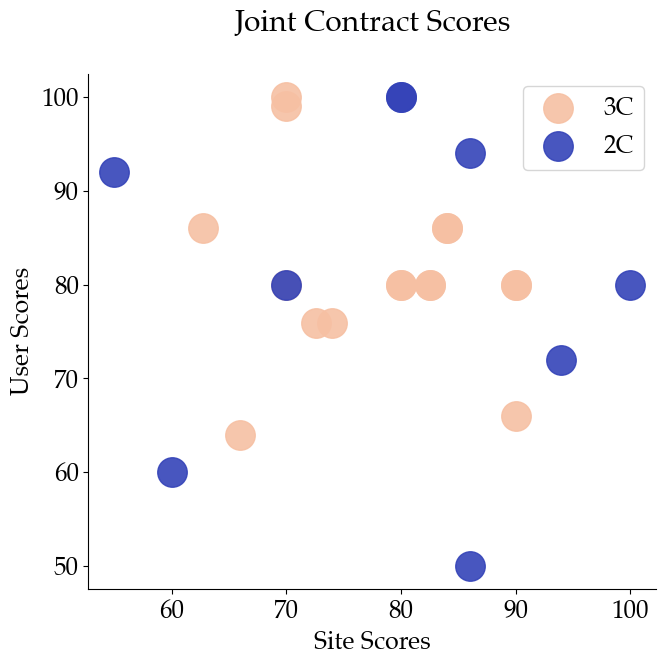

In [236]:
manip_3c_df[['u_persona', 's_persona', 'u_score', 's_score']]


# Scatter plot for original data (blue color)
plt.figure(figsize=(7, 7))
red_color = (246/255, 192/255, 163/255)
blue_color = (52/255, 67/255, 184/255)

plt.scatter(manip_3c_df['s_score'], manip_3c_df['u_score'], s=450, alpha=0.9, color=red_color, label='3C')

# Scatter plot for manip_2c_df (orange color)
plt.scatter(manip_2c_df['s_score'], manip_2c_df['u_score'], s=450, alpha=0.9, color=blue_color, label='2C')

# Adding labels for each point (optional)
#for i, txt in enumerate(manip_3c_df['u_persona'] + ' - ' + manip_3c_df['s_persona']):
#    plt.annotate(txt, (manip_3c_df['u_score'][i], manip_3c_df['s_score'][i]), textcoords="offset points", xytext=(0,10), ha='center')

#for i, txt in enumerate(manip_2c_df['u_persona'] + ' - ' + manip_2c_df['s_persona']):
#    plt.annotate(txt, (manip_2c_df['u_score'][i], manip_2c_df['s_score'][i]), textcoords="offset points", xytext=(0,10), ha='center')

# Adding titles and labels
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Joint Contract Scores\n')
plt.xlabel('Site Scores')
plt.ylabel('User Scores')
plt.grid(False)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()